# DS 5220 Problem Set 3: 
# Decision Trees, Ensemble Methods (Spring 2021)
**Instructor:** Roi Yehoshua
<br>
**Student name:** Weiwei Liu (001404153)
<br>

## 1. Decision Trees

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

### (1) Scratch a tree model:

Reference: codes in the section are mainly from **Sebastian Mantey's tutorial** (https://github.com/SebastianMantey/Decision-Tree-from-Scratch)

In [2]:
# Function to examine if the labele in the data is pure
# Use it at the beginning of the classification
def check_purity(label):
    
    if len(np.unique(label)) == 1:
        return True
    else:
        return False

In [3]:
# Classify based on the class with the max counts
# Use it when the data size is below the min sample limit 
def classify_data(label):
    
    unique_classes, counts_unique_classes = np.unique(label, return_counts=True)
    classification = unique_classes[counts_unique_classes.argmax()]
    
    return classification

In [4]:
# Claculate all potential split points
def get_potential_splits(data):
    
    potential_splits = {}
    
    for i in range(data.shape[1] -1): 
        potential_splits[i] = []
        unique_values = np.unique(data[:, i])
        
        for j in range(len(unique_values)): 
            if j != 0: 
                c = unique_values[j]
                v = unique_values[j-1]
                potential_split = (c + v) / 2
                potential_splits[i].append(potential_split)
        
    return potential_splits

In [5]:
# Split data according the split value assigned
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [6]:
# Calculate the entropy before spliting
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [7]:
# Calculate the entropy in each data split 
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [8]:
# Find the split point with the max information gain
# a.k.a the split point with the min entropy in the split
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999999
    for i in potential_splits:
        for v in potential_splits[i]:
            data_below, data_above = split_data(data, 
                                                split_column=i, 
                                                split_value=v)
            current_overall_entropy = calculate_overall_entropy(data_below, 
                                                                data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = i
                best_split_value = v
    
    return best_split_column, best_split_value

In [9]:
# The main algorithm for decision tree
def decision_tree_algorithm(df, counter=0, 
                            min_samples=2, 
                            max_depth=5):
    
    # Data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df
    
    # Base cases as the begining of classification
    if (check_purity(data[:, -1])) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data[:, -1])
        return classification

    
    # Recursive part
    else:    
        counter += 1

        # Functions to find the split point and to split data
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, 
                                            split_column, 
                                            split_value)
        
        # Check if every branch has nodes
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # Format a dictionary to store split information
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} | <= | {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # Implement the algorithm recursively 
        # Keep going until base cases are met or no node exists at one branch
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # Append the sub tree into the dictionary
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        return sub_tree

In [10]:
# Function to classify based on a trained tree
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" | ")

    # Label examples based on the answer to the split question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # Base case to end the recursive
    # Ensure all examples get a label
    if not isinstance(answer, dict):
        return answer
    
    # Recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [11]:
# Function calculate the prediction accuracy
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df.iloc[:, -2]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

### (2) Test the scratch algorithm with Iris data set

In [12]:
# Import Iris dataset from sklearn.datasets
iris = load_iris(as_frame=True).frame
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [13]:
# Extract feature data and target data
data = iris.iloc[:, :4]
label = iris.iloc[:, 4]

# Training and test split with train_size=0.8
X_train, X_test, y_train, y_test = train_test_split(data, label, 
                                                    train_size=0.8, 
                                                    random_state=15)

In [14]:
# Shape of the training set
X_train.shape

(120, 4)

In [15]:
# Shape of the test set
X_test.shape

(30, 4)

In [16]:
# Produce the data can be used in the scratch algorithm
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [17]:
# Build up and print the tree
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'petal width (cm) | <= | 0.8': [0.0,
                                 {'petal width (cm) | <= | 1.75': [{'petal length (cm) | <= | 4.95': [1.0,
                                                                                                      2.0]},
                                                                   {'petal length (cm) | <= | 4.85': [1.0,
                                                                                                      2.0]}]}]}


### (3) Compare with the model from *sklearn*: 

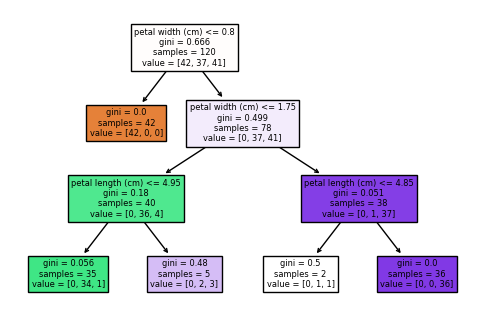

In [23]:
skmodel = DecisionTreeClassifier(max_depth=3)
skmodel = skmodel.fit(X_train, y_train)
y_pred = skmodel.predict(X_test)
plt.figure(dpi = 100)
plot_tree(skmodel, feature_names = load_iris().feature_names, filled=True);

In [19]:
# Calculate the accuracy for scratch model
calculate_accuracy(test_df, tree)

0.9666666666666667

In [20]:
# Calculate the accuracy for sklearn model
accuracy_score(y_test, y_pred)

0.9666666666666667

In the scratch model, the split point is below: 
1. Depth 1: petal width: 0.8
1. Depth 2: petal width: 1.75
1. Depth 3: petal length: 4.95; petal length: 4.85

In the *sklearn* model, the split point is below: 
1. Depth 1: petal width: 0.8
1. Depth 2: petal width: 1.75
1. Depth 3: petal length: 4.95; petal length: 4.85

From the above, we can find that the scratch model produces a completely same tree like the one from the sklearn model. 

## 2. Training Error of Boosting

### 1) Error inequality proof:

$
\begin{align}
f(\mathrm{x}_i) &= \mathrm{sign}(f(\mathrm{x}_i))|f(\mathrm{x}_i)|\\
&= H(\mathrm{x}_i)|f(\mathrm{x}_i)|
\end{align}
$

When $H(\mathrm{x}_i)=y_i$,

$
\begin{align}
\mathrm{exp}(-f(\mathrm{x}_i)y_i) &= \mathrm{exp}(-H(\mathrm{x}_i)|f(\mathrm{x}_i)|y_i)\\
&= \mathrm{exp}(-|f(\mathrm{x}_i)|) \in [0, 1]
\end{align}
$

e.g. $\mathbb{1}(H(\mathrm{x}_i)\neq y_i) = 0 \leq \mathrm{exp}(-f(\mathrm{x}_i)y_i)$

When $H(\mathrm{x}_i)\neq y_i$,

$
\begin{align}
\mathrm{exp}(-f(\mathrm{x}_i)y_i) &= \mathrm{exp}(-H(\mathrm{x}_i)|f(\mathrm{x}_i)|y_i)\\
&= \mathrm{exp}(|f(\mathrm{x}_i)|) \geq 1
\end{align}
$

e.g. $\mathbb{1}(H(\mathrm{x}_i)\neq y_i) = 1 \leq \mathrm{exp}(-f(\mathrm{x}_i)y_i)$

Therefore, $\mathbb{1}(H(\mathrm{x}_i)\neq y_i) \leq \mathrm{exp}(-f(\mathrm{x}_i)y_i)$, 

e.g. $\frac{1}{n} \sum_{i=1}^{n} \mathbb{1}(H(\mathrm{x}_i)\neq y_i) \leq \frac{1}{n} \sum_{i=1}^{n} \mathrm{exp}(-f(\mathrm{x}_i)y_i)$

### 2) Recursive definition of distribution $D_t$: 


According to the recursive definition of $D_t$, we can replace the $D_t$ in $D_{t+1}$ recursively like the following: 

$
\begin{align}
D_{t+1}(i) &= \frac{1}{Z_t} D_t(i) \; \mathrm{exp}(- \alpha_t y_i h_t(\mathrm{x}_i)) \\
&= \frac{1}{Z_{t-1} Z_t} D_{t-1}(i) \; \mathrm{exp}(- y_i (\alpha_t h_t(\mathrm{x}_i) + \alpha_{t-1} h_{t-1}(\mathrm{x}_i))\\
&= \cdots \\
&= \frac{1}{\prod_{t=1}^{T} Z_t} D_1 (i) \; \mathrm{exp}(- y_i (\alpha_t h_t(\mathrm{x}_i) + \cdots + \alpha_1 h_1(\mathrm{x}_i)) \\
&= \frac{1}{\prod_{t=1}^{T} Z_t} \; \frac{1}{n} \; \mathrm{exp}(- y_i f(\mathrm{x}_i))
\end{align}
$

Since adding weights of all $\mathrm{n}$ data points should be 1, 

$
\begin{align}
\sum_{i=1}^{n} D_{t+1}(i) &= \frac{1}{\prod_{t=1}^{T} Z_t} \; \frac{1}{n} \; \sum_{i=1}^{n}\mathrm{exp}(- y_i f(\mathrm{x}_i)) = 1
\end{align}
$

Therefore, $\prod_{t=1}^{T} Z_t= \frac{1}{n} \; \sum_{i=1}^{n}\mathrm{exp}(- y_i f(\mathrm{x}_i))$

### 3) Re-write the formula of $Z_t$: 

$
\begin{align}
Z_t &= \sum_{i=1}^{n} D_t(i) \; \mathrm{exp}(- \alpha_t y_i h_t(\mathrm{x}_i))\\
&= \sum_{y_i h_t(\mathrm{x}_i) = 1}^{} D_t(i) \; \mathrm{exp}(- \alpha_t) + \sum_{y_i h_t(\mathrm{x}_i) = -1}^{} D_t(i) \; \mathrm{exp} (\alpha_t)\\
&= (1-\varepsilon_t) \; \mathrm{exp}(- \alpha_t) + \varepsilon_t \; \mathrm{exp} (\alpha_t)
\end{align}
$

### 4) Proof of $\alpha_t$: 

In order to minimize $Z_t$, we need to take its derivative with respect to $\alpha_t$ and set it to $0$: 

$
\begin{align}
\frac{dZ_t}{d\alpha_t} &= (-1) (1-\varepsilon_t) \; \mathrm{exp}(- \alpha_t) + \varepsilon_t \; \mathrm{exp} (\alpha_t) \\
&= (\varepsilon_t - 1) \; \mathrm{exp}(- \alpha_t) + \varepsilon_t \; \mathrm{exp} (\alpha_t) = 0
\end{align}
$

Therefore, 

$
\begin{align}
(1-\varepsilon_t) \; \mathrm{exp}(- \alpha_t) &= \varepsilon_t \; \mathrm{exp} (\alpha_t) \\
\frac{\mathrm{exp} (\alpha_t)}{\mathrm{exp}(- \alpha_t)} &= \frac{1-\varepsilon_t}{\varepsilon_t} \\
\mathrm{exp}(2\alpha_t) &= \frac{1-\varepsilon_t}{\varepsilon_t} \\
2\alpha_t &= ln (\frac{1-\varepsilon_t}{\varepsilon_t}) \\
\alpha_t &= \frac{1}{2} ln (\frac{1-\varepsilon_t}{\varepsilon_t})
\end{align}
$ 

### 5) Substitute $\alpha_t$ in $Z_t$ with $\varepsilon_t$:

$
\begin{align}
Z_t &= (1-\varepsilon_t) \; \mathrm{exp}(- \alpha_t) + \varepsilon_t \; \mathrm{exp} (\alpha_t) \\
&= (1-\varepsilon_t) \; \sqrt{\frac{\varepsilon_t}{1-\varepsilon_t}} + \varepsilon_t \; \sqrt{\frac{1-\varepsilon_t}{\varepsilon_t}} \\
&= 2 \sqrt{\varepsilon_t(1-\varepsilon_t)}
\end{align}
$

### 6) Proof of $Z_t$ inequality:

$
\begin{align}
Z_t &= 2 \sqrt{\varepsilon_t(1-\varepsilon_t)} \\
&= 2 \sqrt{(\frac{1}{2} - \gamma_t)(\frac{1}{2} + \gamma_t)} \\
&= \sqrt{1 - 4 \gamma_t^2} \\
&= \sqrt{(1 - 2 \gamma_t^2)^2 - (2 \gamma_t^2)^2} \\
&\leq \sqrt{(1 - 2 \gamma_t^2)^2} = 1 - 2 \gamma_t^2 \\
&\leq \mathrm{exp} (-2\gamma_t^2) \\
\end{align}
$

Therefore, with the conclusion proven above, 

$\varepsilon_{training} \leq \prod_{t}^{} Z_t \leq \mathrm{exp} (-2 \sum_{t}^{} \gamma_t^2)$

### 7) Argument about the existence of $\varepsilon_t \leq 0.5$:

If a weak classifier $h_t$ with an error rate $\varepsilon_t$ above $0.5$ exists, then we only need to change the prediction to the opposite so that the incorrect and the correct get flipped for a better classifier under the context of binary output. At this time, the alterred classifier will have an error rate of $1-\varepsilon_t$ which is below 0.5. In each boosting round, only the the best classifier with the lowest error rate will be chosen. Therefore, the training error in this round will be below $0.5$. In other words, the final training error in each round ia always less than $0.5$.

### 8) Argument about $\varepsilon_t = 0.5$ at the stuck point: 

When $\varepsilon_t = 0.5$, 
The $\alpha_t$ minimizing the error in the boosting round will be $\frac{1}{2} ln (\frac{1-0.5}{0.5}) = 0$, and the nomalizer $Z_t$ will be $2 \sqrt{0.5(1-0.5)}=1$, 

e.g. the new distribution $D_{t+1}(i) = 1* D_t(i) \; \mathrm{exp}(- 2-0 * y_i h_t(\mathrm{x}_i)) = D_t(i)$

At this time, the distribution has no change and the boosting round gets stopped. Therefore, the training error will also get "stuck" with no decrease at this time. 

## 3. AdaBoost on a Toy Dataset

### 1) Boosting rounds with $T=4$: 

#### $t=1$: 

$
\begin{align}
D_1 &= [0.25, 0.25, 0.25, 0.25] \\
h_1 &= [-1, -1, +1, -1] \\
\varepsilon_1 &= 1/4 \\
&= 0.25 \\
\alpha_1 &= \frac{1}{2} ln (\frac{1-0.25}{0.25}) \\
&= 0.5493 \\
Z_1 &= 2 \sqrt{0.25(1-0.25)} \\
&= 0.866 \\
\end{align}
$

#### $t=2$: 

$
D_2 = 
\begin{bmatrix}
\frac{1}{Z_1} D_1(1) \; \mathrm{exp}(- \alpha_1 y_1 h_1(\mathrm{x}_1)) = 0.1667\\
\frac{1}{Z_1} D_1(2) \; \mathrm{exp}(- \alpha_1 y_2 h_1(\mathrm{x}_2)) = 0.5\\
\frac{1}{Z_1} D_1(3) \; \mathrm{exp}(- \alpha_1 y_3 h_1(\mathrm{x}_3)) = 0.1667\\
\frac{1}{Z_1} D_1(4) \; \mathrm{exp}(- \alpha_1 y_4 h_1(\mathrm{x}_4)) = 0.1667
\end{bmatrix}
$

$
\begin{align}
h_2 &= [1, 1, 1, -1] \\
\varepsilon_2 &= \sum_{i=1}^{4}  D_2(i) \mathbb{1}(H(\mathrm{x}_i)\neq y_i) \\
&= 0.1667 \\
\alpha_2 &= \frac{1}{2} ln (\frac{1-0.1667}{0.1667}) \\
&= 0.8047 \\
Z_2 &= 2 \sqrt{0.1667(1-0.1667)} \\
&= 0.7454 \\
\end{align}
$

#### $t=3$: 

$
D_3 = 
\begin{bmatrix}
\frac{1}{Z_2} D_2(1) \; \mathrm{exp}(- \alpha_2 y_1 h_2(\mathrm{x}_1)) = 0.5\\
\frac{1}{Z_2} D_2(2) \; \mathrm{exp}(- \alpha_2 y_2 h_2(\mathrm{x}_2)) = 0.3\\
\frac{1}{Z_2} D_2(3) \; \mathrm{exp}(- \alpha_2 y_3 h_2(\mathrm{x}_3)) = 0.1\\
\frac{1}{Z_2} D_2(4) \; \mathrm{exp}(- \alpha_2 y_4 h_2(\mathrm{x}_4)) = 0.1
\end{bmatrix}
$

$
\begin{align}
h_3 &= [-1, 1, -1, -1] \\
\varepsilon_3 &= \sum_{i=1}^{4}  D_3(i) \mathbb{1}(H(\mathrm{x}_i)\neq y_i) \\
&= 0.1 \\
\alpha_3 &= \frac{1}{2} ln (\frac{1-0.1}{0.1}) \\
&= 1.0986 \\
Z_3 &= 2 \sqrt{0.1(1-0.1)} \\
&= 0.6 \\
\end{align}
$

#### $t=4$: 

$
D_4 = 
\begin{bmatrix}
\frac{1}{Z_3} D_3(1) \; \mathrm{exp}(- \alpha_3 y_1 h_2(\mathrm{x}_1)) = 0.2778\\
\frac{1}{Z_3} D_3(2) \; \mathrm{exp}(- \alpha_3 y_2 h_2(\mathrm{x}_2)) = 0.1667\\
\frac{1}{Z_3} D_3(3) \; \mathrm{exp}(- \alpha_3 y_3 h_2(\mathrm{x}_3)) = 0.5\\
\frac{1}{Z_3} D_3(4) \; \mathrm{exp}(- \alpha_3 y_4 h_2(\mathrm{x}_4)) = 0.0556
\end{bmatrix}
$

$
\begin{align}
h_4 &= [-1, 1, 1, -1] \\
\varepsilon_4 &= \sum_{i=1}^{4}  D_4(i) \mathbb{1}(H(\mathrm{x}_i)\neq y_i) \\
&= 0.0556 \\
\alpha_4 &= \frac{1}{2} ln (\frac{1-0.0556}{0.0556}) \\
&= 1.4166 \\
Z_4 &= 2 \sqrt{0.0556(1-0.0556)} \\
&= 0.4581 \\
\end{align}
$

### 2) Training error with $T=4$: 

$
H(\mathrm{x}) = 
\begin{bmatrix}
\sum \alpha_t h_t(\mathrm{x}_1) = -2.3\\
\sum \alpha_t h_t(\mathrm{x}_2) = 2.8\\
\sum \alpha_t h_t(\mathrm{x}_3) = 1.7\\
\sum \alpha_t h_t(\mathrm{x}_4) = -3.9
\end{bmatrix}
$

$f(\mathrm{x}) = \mathrm{sign}(H(\mathrm{x})) = [-1, 1, 1, -1]$

After comparing with the original label $[-1, 1, 1, -1]$, we get all correct classificaiton. Therefore, the training error is 0.

### 3) Explanation on AdaBoost's greatness:

From the Figure 1a, we can see that all "+" are at the edge and all "-" are in the middle. Therefore, it can't be classified with a simple linear seperation. With AdaBoost, the classification process can take multiple rounds and each round will produce a classifier with a corresponding weight distribution. The final classification will be based on the combination of all information (a.k.a all weight distributions) so that a nonlinear classification boundary will be provided. 